# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [205]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import model_selection

data = pd.read_csv('spam_or_not_spam.zip')
data.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


In [206]:
# рассчитайте частоты для классов
data['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

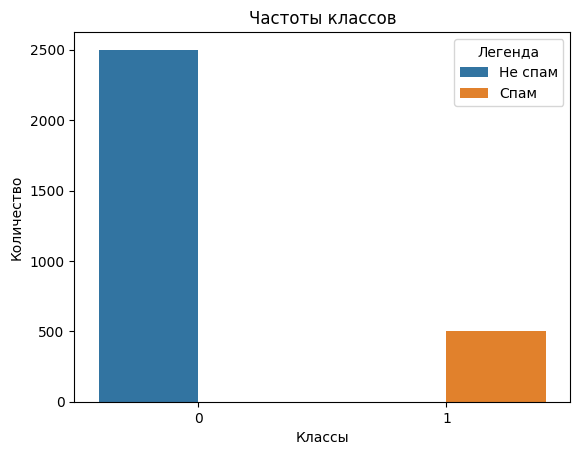

In [207]:
# визуализируйте результат
ax = sns.countplot(data=data, x='label', hue='label', hue_order=[0, 1])
ax.set_title('Частоты классов')
ax.set_xlabel('Классы')
ax.set_ylabel('Количество')

legend_labels = {0: 'Не спам', 1: 'Спам'}
plt.legend(title='Легенда', labels=legend_labels.values())

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [208]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [209]:
data['email'] = data['email'].replace('^\s+$', '', regex=True)
data['email'] = data['email'].replace('', np.nan)
data = data.dropna(axis=0)
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2997 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   2997 non-null   object
 1   label   2997 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 70.2+ KB


Переводим данные в векторный вид:

In [210]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['email'])

Определите, сколько теперь признаков в нашем наборе данных:

In [211]:
X.shape

(2997, 34116)

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [212]:
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [213]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    train_size=0.75,
    test_size=0.25,
    stratify=y,
    random_state=42,
)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [214]:
y_test.mean()

0.16533333333333333

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [246]:
# Поскольку у нас текст и несбалансированная выборка, то будем использовать ComplementNB
# (можно и MultinomialNB, но он показал худшие метрики) классификатор
from sklearn.naive_bayes import ComplementNB, MultinomialNB

alpha = 0.01

classificator = ComplementNB(alpha=alpha)
classificator.fit(X_train, y_train)

y_train_pred = classificator.predict(X_train)
y_test_pred = classificator.predict(X_test)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [248]:
print('Accuracy на тренировочной выборке: {:.4f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Recall на тренировочной выборке: {:.4f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Precission на тренировочной выборке: {:.4f}'.format(metrics.precision_score(y_train, y_train_pred)))
print('F1 score на тренировочной выборке: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))

print('\nAccuracy на тестовой выборке: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Recall на тестовой выборке: {:.4f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Precission на тестовой выборке: {:.4f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('F1 score на тестовой выборке: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))


Accuracy на тренировочной выборке: 0.9996
Recall на тренировочной выборке: 0.9973
Precission на тренировочной выборке: 1.0000
F1 score на тренировочной выборке: 0.9987

Accuracy на тестовой выборке: 0.9880
Recall на тестовой выборке: 0.9274
Precission на тестовой выборке: 1.0000
F1 score на тестовой выборке: 0.9623


### Выводы
* метрика $precission = 1.0$ показывает, что вероятность допустить ошибку I рода (отметить хорошее письмо как спам) стремиться к нулю
* не смотря на довольно большое значение метрики $accuracy = 0.988$, принимать во внимание ее не будем, поскольку наша выборка не сбалансирована.
* $F_1-score = 0.9623$ показывает хороший результат, но попробуем его улучшить ниже
* метрика $recall = 0.9274$ показывает, что процент писем, которые модель определила к спаму, среди всех действительно писем со спамом составляет 95.74%, что в полне удовлетворительно - пропустить какой-то процент писем со спамом лучше, чем отметить хорошее письмо как спам.

Нарисуйте ROC-кривую:

ROC-AUC на тестовой выборке: 0.987


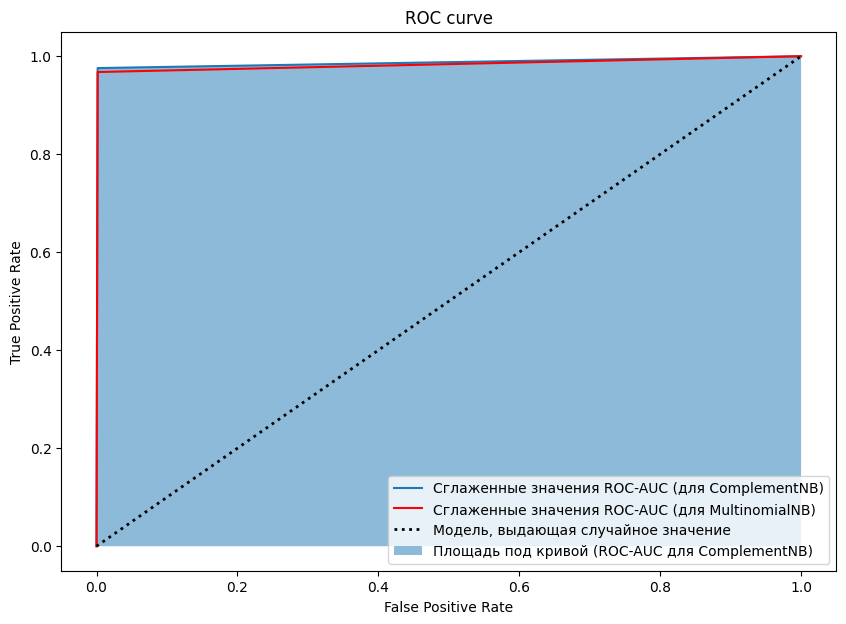

In [293]:
def get_roc_curve(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return metrics.roc_curve(y_test, model.predict(X_test))

false_positive_rates, true_positive_rates, threshold = get_roc_curve(
    ComplementNB(alpha=alpha),
    X_train, y_train, X_test, y_test
)

false_positive_rates_m, true_positive_rates_m, threshold_m = get_roc_curve(
    MultinomialNB(alpha=alpha),
    X_train, y_train, X_test, y_test
)

roc_auc = metrics.roc_auc_score(y_test, y_test_pred).round(3)
print("ROC-AUC на тестовой выборке:", roc_auc)

# создаём график
plt.figure(figsize=(10, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates,
         label='Сглаженные значения ROC-AUC (для ComplementNB)')

plt.plot(false_positive_rates_m, true_positive_rates_m, color='red',
         label='Сглаженные значения ROC-AUC (для MultinomialNB)')

# кривая, соответствующая случайному угадыванию
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':',
         label='Модель, выдающая случайное значение')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.fill_between(false_positive_rates, true_positive_rates,
                 alpha=0.5, label='Площадь под кривой (ROC-AUC для ComplementNB)')
plt.legend()
plt.show()

### Вывод
* Из графика кривых видно, что площадь под кривой у модели ComplementNB больше, чем у MultinomialNB

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [294]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

param_grid = {
    'alpha': np.linspace(0, 1, 200),
}

clf = ComplementNB(force_alpha=True)
grid_search = model_selection.GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
)

%time grid_search.fit(X_train, y_train)
y_test_pred = grid_search.predict(X_test)

print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))
print('\nAccuracy на тестовой выборке: {:.4f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Recall на тестовой выборке: {:.4f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('Precission на тестовой выборке: {:.4f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('F1 score на тестовой выборке: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

CPU times: user 2.08 s, sys: 237 ms, total: 2.32 s
Wall time: 2.35 s
Наилучшие значения гиперпараметров: {'alpha': 0.33668341708542715}

Accuracy на тестовой выборке: 0.9947
Recall на тестовой выборке: 0.9758
Precission на тестовой выборке: 0.9918
F1 score на тестовой выборке: 0.9837


[Text(0.0, 0, '0'),
 Text(0.2, 0, '0.2'),
 Text(0.3367, 0, '0.3367'),
 Text(0.4, 0, '0.4'),
 Text(0.6, 0, '0.6'),
 Text(0.8, 0, '0.8'),
 Text(1.0, 0, '1')]

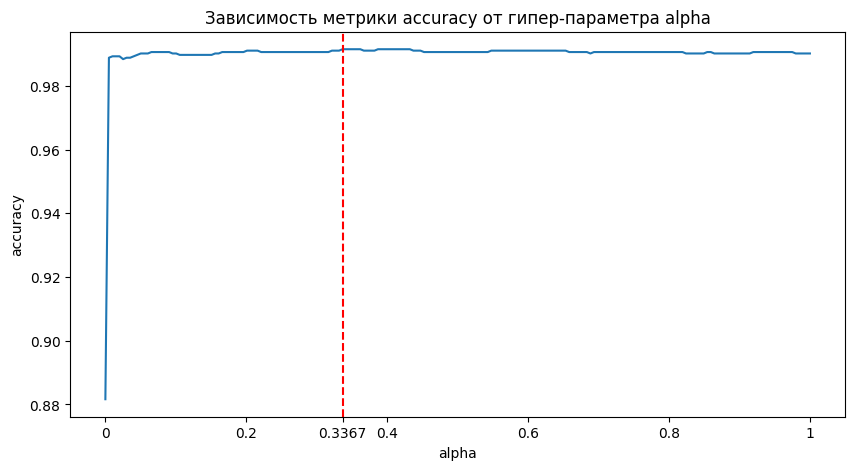

In [287]:
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x=grid_search.cv_results_['param_alpha'], y=grid_search.cv_results_['mean_test_score'])
ax.set_title('Зависимость метрики accuracy от гипер-параметра alpha')
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.axvline(
    x=grid_search.best_params_['alpha'],
    color='red',
    linestyle='dashed',
)
x_labels = [0, 0.2, round(grid_search.best_params_['alpha'], 4), 0.4, 0.6, 0.8, 1]
ax.set_xticks(x_labels)
ax.set_xticklabels(x_labels)


### Выводы
* при $\alpha = 0.3367$ улучшились метрики: 
    * $accuracy = 0.9947$ (было 0.9880)
    * $recall = 0.9758$ (было 0.9274)
    * $F_1 score = 0.9837$ (было 0.9623)
* метрика $precission = 0.9918$ ухудшилась (было 1.0)
* можно сказать, что гипер-параметр $\alpha$ влияет на качество классификации